# Illuminating the Latent Space of an MNIST GAN

One of the most popular applications of [Generative Adversarial Networks](https://en.wikipedia.org/wiki/Generative_adversarial_network) is generating fake images. In particular, websites like [this person does not exist](https://thispersondoesnotexist.com) serve a GAN that generates fake images of people ([this x does not exist](https://thisxdoesnotexist.com) provides a comprehensive list of such websites). Such websites are entertaining, especially when one is asked to figure out [which face is real](https://www.whichfaceisreal.com/index.php).

Usually, these websites extract fake images by sampling the GAN’s latent space. For those unfamiliar with GANs, this means that each image is associated with a real valued vector of $n$ components. But since these vectors are typically generated randomly, the usefulness of these websites breaks down when we wish to search for a specific image.

For instance, suppose that instead of fake faces, we want to generate fake handwriting, specifically the digit eight (8). We could train a GAN on the MNIST dataset and produce a generator network that generates fake digits. Now, we can repeatedly sample the latent space until an eight appears. However, if we want to _find_ an eight, we could optimize latent space directly with CMA-ES. To ensure that we generate eights, we could use the output classification prediction of a LeNet-5 classifier as the objective (see [Bontrager 2018](https://arxiv.org/abs/1705.07386)).<sup>1</sup> But notice that the latent space likely contains many examples of the digit eight, and they might vary in the weight of the pen stroke or the lightness of the ink color. If we make these properties our measures, we could search latent space for many different examples of eight in a single run!

[Fontaine 2021](https://arxiv.org/abs/2007.05674) takes exactly this approach when generating new levels for the classic video game [Super Mario Bros](https://en.wikipedia.org/wiki/Super_Mario_Bros). They term this approach “Latent Space Illumination”, as they explore quality diversity (QD) algorithms (including [CMA-ME](https://arxiv.org/pdf/1912.02400.pdf)) as a method to search the latent space of a video game level GAN and illuminate the behavior space of possible level mechanics. In this tutorial, we illuminate the latent space of the aforementioned MNIST GAN by mimicking the approach taken in [Fontaine 2021](https://arxiv.org/abs/2007.05674).

**(1)** Since the discriminator of the GAN is only trained to evaluate how realistic an image is, it cannot detect specific digits. Hence, we need the LeNet-5 to check that the digit is an 8.

## Setup

First, we install pyribs, PyTorch, and several utilities.

In [1]:
%pip install ribs torch==1.7 torchvision==0.8 numpy matplotlib

     |████████████████████████████████| 108.0 MB 101 kB/s  eta 0:00:01
     |████████████████████████████████| 1.0 MB 23.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

Below, we check what device is available for PyTorch. On Colab, activate the GPU by clicking "Runtime" in the toolbar at the top. Then, click "Change Runtime Type", and select "GPU".

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Loading the GAN and Classifier

For this tutorial, we pretrained a GAN that generates MNIST digits using the code from [a beginner GAN tutorial](https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/). We also pretrained a [LeNet-5](https://en.wikipedia.org/wiki/LeNet) classifier for the MNIST dataset using the code [here](https://github.com/icaros-usc/pyribs/tree/master/examples/tools/train_mnist_classifier.py). Below, we define the network structures.

In [4]:
class Generator(nn.Module):
    """Generator network for the GAN."""

    def __init__(self, nz):
        super(Generator, self).__init__()

        # Size of the latent space (number of dimensions).
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    """Discriminator network for the GAN."""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) log probabilities
).to(device)
LENET5_MEAN_TRANSFORM = 0.1307
LENET5_STD_DEV_TRANSFORM = 0.3081

Next, we load the pretrained weights for each network.

In [5]:
import os
from urllib.request import urlretrieve
from pathlib import Path

LOCAL_DIR = Path("lsi_mnist_weights")
LOCAL_DIR.mkdir(exist_ok=True)
WEB_DIR = "https://raw.githubusercontent.com/icaros-usc/pyribs/master/examples/tutorials/_static/"

# Download the model files to LOCAL_DIR.
for filename in [
        "mnist_generator.pth",
        "mnist_discriminator.pth",
        "mnist_classifier.pth",
]:
    model_path = LOCAL_DIR / filename
    if not model_path.is_file():
        urlretrieve(WEB_DIR + filename, str(model_path))

# Load the weights of each network from its file.
g_state_dict = torch.load(
    str(LOCAL_DIR / "mnist_generator.pth"),
    map_location=device,
)
d_state_dict = torch.load(
    str(LOCAL_DIR / "mnist_discriminator.pth"),
    map_location=device,
)
c_state_dict = torch.load(
    str(LOCAL_DIR / "mnist_classifier.pth"),
    map_location=device,
)

# Instantiate networks and insert the weights.
generator = Generator(nz=128).to(device)
discriminator = Discriminator().to(device)
generator.load_state_dict(g_state_dict)
discriminator.load_state_dict(d_state_dict)
LENET5.load_state_dict(c_state_dict)

<All keys matched successfully>

## LSI with CMA-ME on MNIST GAN

After loading the GAN and the classifier, we can begin exploring the latent space of the GAN with the pyribs implementation of CMA-ME. Thus, we import and initialize the `GridArchive`, `ImprovementEmitter`, and `Optimizer` from pyribs.

For the `GridArchive`, we choose a 2D behavior space with "boldness" and "lightness" as the behavior characteristics. We approximate "boldness" of a digit by counting the number of white pixels in the image, and we approximate "lightness" by averaging the values of the white pixels in the image. We define a "white" pixel as a pixel with value at least 0.5 (pixels are bounded to the range $[0,1]$). Since there are 784 pixels in an image, boldness is bounded to the range $[0, 784]$. Meanwhile, lightness is bounded to the range $[0.5, 1]$, as that is the range of a white pixel.

In [6]:
from ribs.archives import GridArchive

archive = GridArchive(
    solution_dim=generator.nz,
    dims=[200, 200],  # 200 bins in each dimension.
    ranges=[(0, 784), (0.5, 1)],  # Boldness range, lightness range.
)

Next, we use 5 instances of `ImprovementEmitter`, each with batch size of 30. Each emitter begins with a zero vector of the same dimensionality as the latent space and an initial step size $\sigma=0.2$.

In [7]:
from ribs.emitters import EvolutionStrategyEmitter

# We use the EvolutionStrategyEmitter passing in ranker="2imp" to create a ImprovementEmitter.
emitters = [
    EvolutionStrategyEmitter(
        archive=archive,
        x0=np.zeros(generator.nz),
        sigma0=0.2,  # Initial step size.
        ranker="2imp",
        batch_size=30,
    ) for _ in range(5)  # Create 5 separate emitters.
]

Finally, we construct the optimizer to connect the archive and emitters together.

In [9]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

With the components created, we now generate latent vectors. As we use 5 emitters with batch size of 30 and run 30,000 iterations, we evaluate 30,000 * 30 * 5 = 4,500,000 latent vectors in total. This loop should take **15-30 min** to run.

In [9]:
total_itrs = 30_000
flat_img_size = 784  # 28 * 28
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = scheduler.ask()

    with torch.no_grad():
        tensor_sols = torch.tensor(
            sols,
            dtype=torch.float32,
            device=device,
        )

        # Shape: len(sols) x 1 x 28 x 28
        generated_imgs = generator(tensor_sols)

        # Normalize the images from [-1,1] to [0,1].
        normalized_imgs = (generated_imgs + 1.0) / 2.0

        # We optimize the score of the digit being 8. Other digits may also be
        # used.
        lenet5_normalized = ((normalized_imgs - LENET5_MEAN_TRANSFORM) /
                             LENET5_STD_DEV_TRANSFORM)
        objs = torch.exp(LENET5(lenet5_normalized)[:, 8]).cpu().numpy()

        # Shape: len(sols) x 784
        flattened_imgs = normalized_imgs.cpu().numpy().reshape(
            (-1, flat_img_size))

        # The first measures is the "boldness" of the digit (i.e. number of white
        # pixels). We consider pixels with values larger than or equal to 0.5
        # to be "white".
        # Shape: len(sols) x 1
        boldness = np.count_nonzero(flattened_imgs >= 0.5,
                                    axis=1,
                                    keepdims=True)

        # The second measures is the "lightness" of the digit (i.e. the mean value of
        # the white pixels).
        # Shape: len(sols) x 1
        flattened_imgs[flattened_imgs < 0.5] = 0  # Set non-white pixels to 0.
        # Add 1 to avoid dividing by zero.
        lightness = (np.sum(flattened_imgs, axis=1, keepdims=True) /
                     (boldness + 1))

        # Each measures entry is [boldness, lightness].
        meas = np.concatenate([boldness, lightness], axis=1)

    optimizer.tell(objs, meas)

    if itr % 1000 == 0:
        print(
            f"Iteration {itr} complete after {time.time() - start_time:.2f}s - "
            f"Archive size: {len(archive.as_pandas(include_solutions=False))}")

Iteration 1000 complete after 39.17980217933655s - Archive size: 13171
Iteration 2000 complete after 72.20655941963196s - Archive size: 15408
Iteration 3000 complete after 107.56191420555115s - Archive size: 15640
Iteration 4000 complete after 138.75481128692627s - Archive size: 15986
Iteration 5000 complete after 173.41253542900085s - Archive size: 16378
Iteration 6000 complete after 202.84771490097046s - Archive size: 16476
Iteration 7000 complete after 231.2869167327881s - Archive size: 16927
Iteration 8000 complete after 258.17751288414s - Archive size: 17018
Iteration 9000 complete after 285.6783549785614s - Archive size: 17149
Iteration 10000 complete after 315.4162104129791s - Archive size: 17196
Iteration 11000 complete after 342.89622044563293s - Archive size: 17284
Iteration 12000 complete after 370.1462724208832s - Archive size: 17340
Iteration 13000 complete after 401.8246293067932s - Archive size: 17502
Iteration 14000 complete after 436.1385066509247s - Archive size: 1777

In [1]:
from torchvision.utils import make_grid


def show_grid_img(x_start,
                  x_num,
                  x_step_size,
                  y_start,
                  y_num,
                  y_step_size,
                  archive,
                  figsize=(8, 6)):
    """Displays a grid of images from the archive.
    
    Args:
        x_start (int): Starting index along x-axis.
        x_num (int): Number of images to generate along x-axis.
        x_step_size (int): Index step size along x-axis.
        y_start (int): Starting index along y-axis.
        y_num (int): Number of images to generate along y-axis.
        y_step_size (int): Index step size along y-axis.
        archive (GridArchive): Archive with results from CMA-ME.
        figsize ((int, int)): Size of the figure for the image.
    """
    x_range = np.arange(x_start, x_start + x_step_size * x_num, x_step_size)
    y_range = np.arange(y_start, y_start + y_step_size * y_num, y_step_size)
    grid_indices = [(x, y) for y in np.flip(y_range) for x in x_range]

    imgs = []
    img_size = (28, 28)
    df = archive.as_pandas()
    solutions, indices = df.batch_solutions(), df.batch_indices()
    for index in grid_indices:
        try:
            sol = solutions[np.where(indices == archive.ravel_index(index))][0]
        except IndexError:
            print(f"There is no solution at index {index}.")
            return

        with torch.no_grad():
            img = generator(
                torch.tensor(sol.reshape(1, generator.nz),
                             dtype=torch.float32,
                             device=device))
            # Normalize images to [0,1].
            normalized = (img.reshape(1, *img_size) + 1) / 2
            imgs.append(normalized)

    plt.figure(figsize=figsize)
    img_grid = make_grid(imgs, nrow=x_num, padding=0)
    plt.imshow(np.transpose(img_grid.cpu().numpy(), (1, 2, 0)),
               interpolation='nearest',
               cmap='gray')

    # Change labels to be BC values.
    plt.xlabel("Boldness")
    plt.ylabel("Lightness")
    x_ticklabels = [
        round(archive.boundaries[0][i])
        for i in [x_start + x_step_size * k for k in range(x_num + 1)]
    ]
    y_ticklabels = [
        round(archive.boundaries[1][i], 2) for i in [
            y_start + y_step_size * y_num - y_step_size * k
            for k in range(y_num + 1)
        ]
    ]
    plt.xticks([img_size[0] * x for x in range(x_num + 1)], x_ticklabels)
    plt.yticks([img_size[0] * x for x in range(y_num + 1)], y_ticklabels)

## Visualization

Below, we visualize the archive after all evaluations. The x-axis is the boldness and the y-axis is the lightness. The color indicates the objective value. We can see that we found many images that the classifier strongly believed to be an eight.

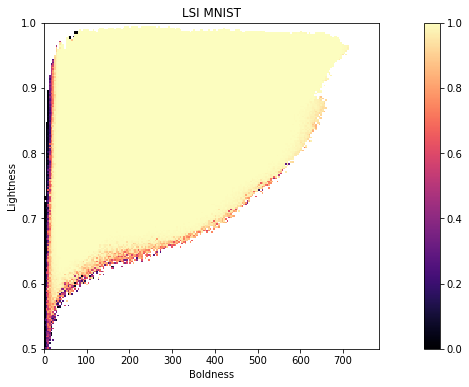

In [10]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=0.0, vmax=1.0)
plt.title("LSI MNIST")
plt.xlabel("Boldness")
plt.ylabel("Lightness")
plt.show()

Next, we display a grid of digits generated from a selected set of latent vectors in the archive.

As we can see below, digits get bolder as we go along the x-axis. Meanwhile, as we go along the y-axis, the digits get brighter. For instance, the image in the bottom right corner is grey and bold, while the image in the top left corner is white and thin.

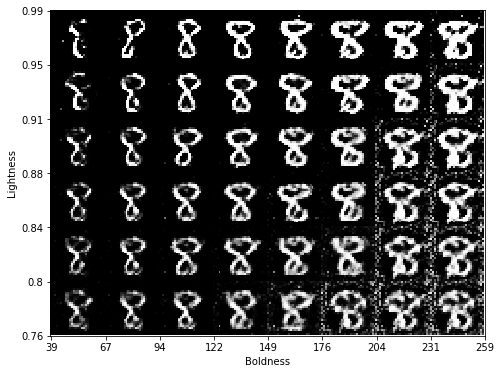

In [12]:
show_grid_img(10, 8, 7, 105, 6, 15, archive)

Here we display images from a wider range of the archive. Note that in order to generate images with high boldness values, CMA-ME generated images that do not look realistic (see the bottom right corner in particular).

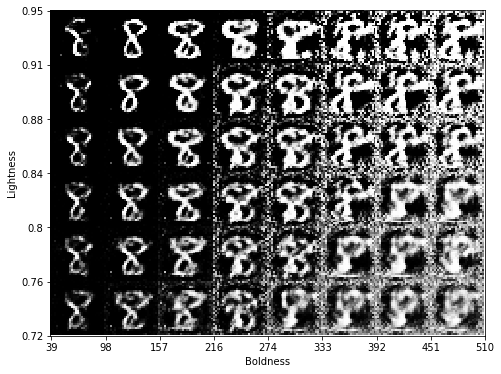

In [13]:
show_grid_img(10, 8, 15, 90, 6, 15, archive)

To determine how realistic all of the images in the archive are, we can evaluate them with the discriminator network of the GAN. Below, we create a new archive where the objective value of each solution is the discriminator score. BCs remain the same.

In [14]:
discriminator_archive = GridArchive(
    solution_dim=generator.nz,
    dims=[200, 200],  # 200 bins in each dimension.
    ranges=[(0, 784), (0.5, 1)],  # Boldness range, lightness range.
)

# Evaluate each solution in the archive and insert it into the new archive.
for elite in archive:
    # No need to normalize to [0, 1] since the discriminator takes in images in
    # the range [-1, 1].
    img = generator(
        torch.tensor(elite.sol.reshape(1, generator.nz),
                     dtype=torch.float32,
                     device=device))
    obj = discriminator(img).item()
    discriminator_archive.add(elite.sol, obj, elite.beh)

Now, we can plot a heatmap of the archive with the discriminator score. The large regions of low score (in black) show that many images in the archive are not realistic, even though LeNet-5 had high confidence that these images showed the digit eight.

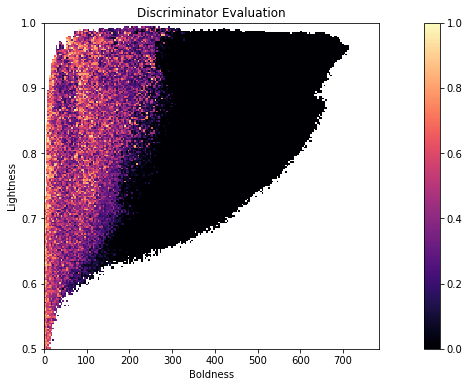

In [15]:
plt.figure(figsize=(8, 6))
grid_archive_heatmap(discriminator_archive, vmin=0.0, vmax=1.0)
plt.title("Discriminator Evaluation")
plt.xlabel("Boldness")
plt.ylabel("Lightness")
plt.show()

## Conclusion

By searching the latent space of an MNIST GAN, CMA-ME found images of the digit eight that varied in boldness and lightness. Even though the LeNet-5 network had high confidence that these images were eights, it turned out that many of these images were highly unrealistic --- when we evaluated them with the GAN's discriminator network, the images mostly received low scores.

_In short, we found that large portions of the GAN's latent space are unrealistic_. This is not surprising because during training, the GAN generates fake images by randomly sampling the latent space from a fixed Gaussian distribution, and some portions of the distribution are less likely to be sampled. Thus, we have the following questions, which we leave open for future exploration:

- How can we ensure that CMA-ME searches for realistic eights?
- While searching for realistic eights, can we also search for other digits at the same time?

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_lsi_mnist,
  title   = {Illuminating the Latent Space of an MNIST GAN},
  author  = {Yulun Zhang and Bryon Tjanaka and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2021},
  url     = {https://docs.pyribs.org/en/stable/tutorials/lsi_mnist.html}
}
```